<a href="https://colab.research.google.com/github/mmaruthi/Deep_Learning_EVA4_Phase1/blob/master/S15-A/Trial-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mmaruthi/EVA4-Data

Cloning into 'EVA4-Data'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 59 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


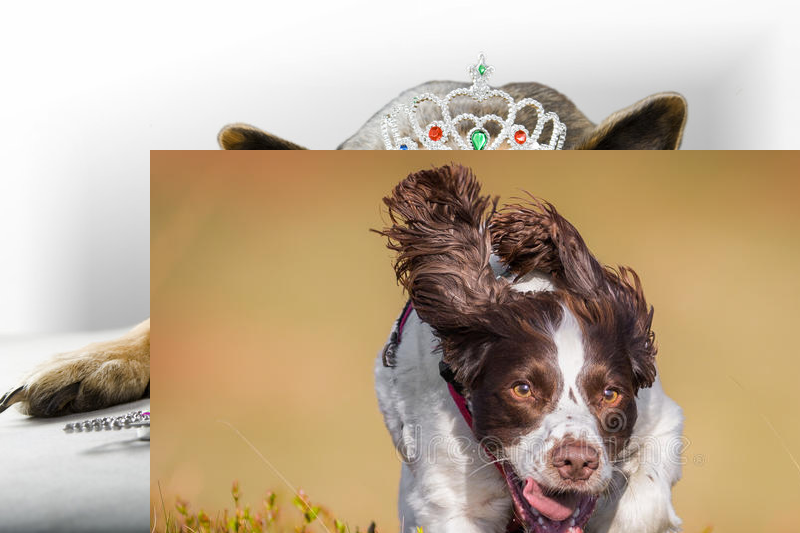

In [13]:
from tqdm.notebook import tqdm, trange
from PIL import Image 
import os
from skimage import io

im1 = Image.open('/content/sample_data/Dog9.jpg')
im2 = Image.open('/content/EVA4-Data/Dogs/Dog1.jpg')

Image.Image.paste(im1, im2, (150,150))

#path = '/content/EVA4-Data/Dogs/'

#sizedict = {}
#for filename in os.listdir(path):
#  im2 = Image.open(f'{path}{filename}')
  #, as_gray=False, pilmode="RGB")
# Image.Image.paste(im1, im2, (0,0))
  
im1.show()
im1

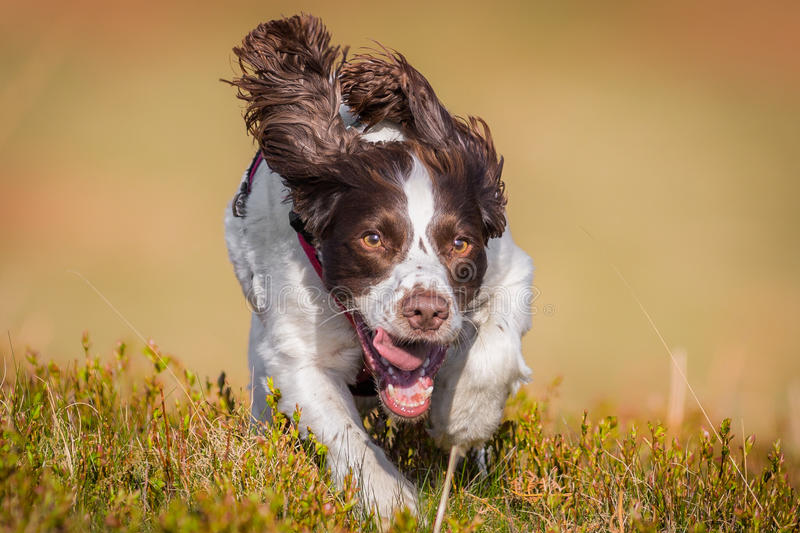

In [9]:
im1

In [0]:
import json
annot = json.load(open('/content/EVA4-Data/Dogs_annotations.json'))

# Data Clustering #

In [0]:
import numpy as np 
import pandas as pd 
import math
df = pd.DataFrame()

data = []
for k, v in annot.items():
  for r in v['regions']:
    d = {'name': v['filename'] }
    s = r['shape_attributes']
    h, w = sizedict[v['filename']]
    d['h'] = s['height']
    d['w'] = s['width']
    d['x'] = s['x']
    d['y'] = s['y']
    d['image_w'] = w
    d['image_h'] = h
    d['height'] = s['height']/h
    d['width'] = s['width']/w
    d['log_height'] = math.log(s['height']/h)
    d['log_width'] = math.log(s['width']/h)

    data.append(d)


df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,name,h,w,x,y,image_w,image_h,height,width,log_height,log_width
0,Dog1.jpg,482,349,203,20,800,572,0.842657,0.436250,-0.171195,-0.494067
1,Dog2.jpg,834,551,56,5,636,900,0.926667,0.866352,-0.076161,-0.490660
2,Dog3.jpg,515,631,115,5,800,530,0.971698,0.788750,-0.028710,0.174429
3,Dog4.jpg,799,438,166,35,644,900,0.887778,0.680124,-0.119034,-0.720176
4,Dog5.jpg,430,362,202,379,636,900,0.477778,0.569182,-0.738610,-0.910751


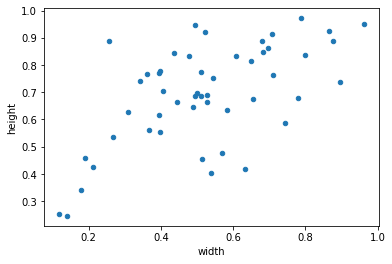

In [0]:
df.plot.scatter('width', 'height')


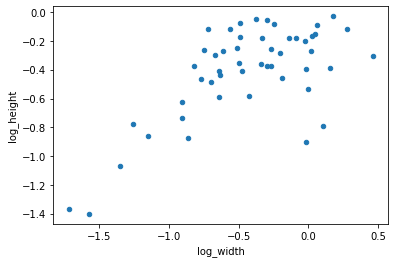

In [0]:
df.plot.scatter('log_width', 'log_height')



K Means clustering
Using Scikit learn's K Means with k from 1 to 20

In [0]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt


Get the X by using log of width and height

In [0]:

X = df[['log_width', 'log_height']].to_numpy()


IOU Calculation
Below method will find the best centroid for a given bounding box

In [0]:
# given centroids find the maximum IOU of a bbox
def iou(box, centroids):
    x = np.minimum(np.exp(centroids[:, 0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroids[:, 1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroids[:, 0]) * np.exp(centroids[:, 1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    #return iou_
    return (np.max(iou_), np.argmax(iou_))


Execute K Means
Now let us run our kmeans. We will calculate for each value of k

distortions
inertias
cluster memberships
cluster centroids
mean of maximum IOU between bounding boxes and individual anchors

In [0]:

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
centroids = {}
memberships = {}
miou = []
K = range(1, 21)

for k in K:
  kmeansModel = KMeans(n_clusters=k).fit(X)
  distortions.append(sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
  inertias.append(kmeansModel.inertia_) 

  mapping1[k] = sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                'euclidean'),axis=1)) / X.shape[0] 
  mapping2[k] = kmeansModel.inertia_ 
  centroids[k] = kmeansModel.cluster_centers_
  maxiou = np.array([iou(b, centroids[k])  for b in X])
  memberships[k] = maxiou[:, 1].astype(np.uint8)
  # find mean of maximum IOU between bounding boxes and individual anchors
  miou.append(np.mean(maxiou[:, 0]))

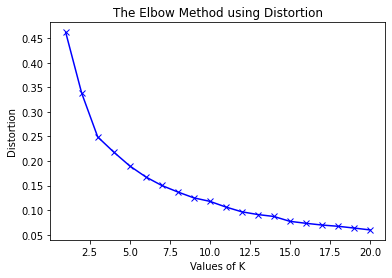

In [0]:

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

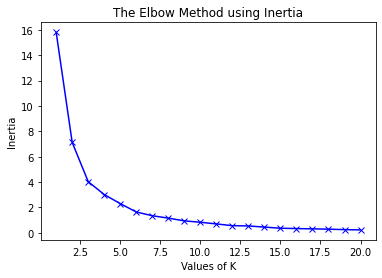

In [0]:

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Plot centroid vs mean IOU

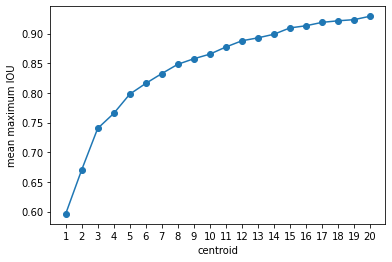

In [0]:

def plotIOU(X, Y):
  plt.scatter(X, Y)
  plt.plot(X, Y)
  plt.xlabel("centroid")
  plt.ylabel("mean maximum IOU")
  plt.xticks(np.arange(1, 21))
  plt.show()

plotIOU(K, miou)

While from both of above plots K=3 seems to be doing OK, but 5 is also not a bad choice. Becase after 5, mostly it is liner with a flat slope. Let us do k = 3 to 6 and visualize

Cluster Plots

In [0]:
import seaborn as sns
def plotclusters(k):
  #ax = df.plot.scatter('log_width', 'log_height', c=f'cluster{k}', colormap='viridis')
  ax = sns.scatterplot('log_width', 'log_height', data=df, hue=memberships[k], style = memberships[k], palette="Set2")
  ax.scatter(centroids[k][:,0], centroids[k][:,1], marker='*', c='black')
  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


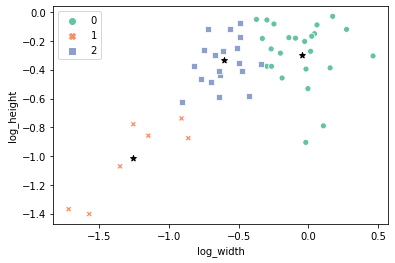

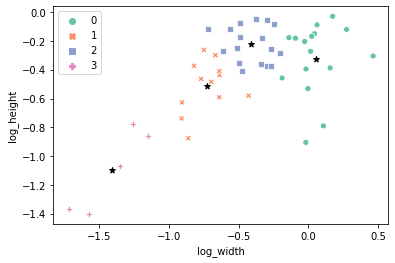

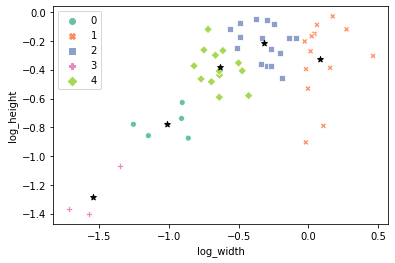

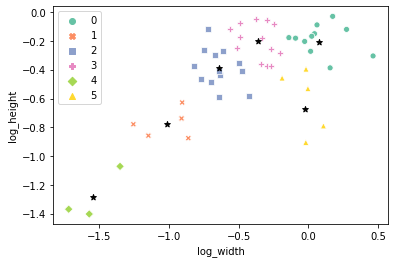

In [0]:

for k in [3, 4, 5, 6]:
  plotclusters(k)


Customized K Means
While above works well, however while we are using membership based upon max IOU, we are using other default distance metric to find which cluster is close to a point in K means. That is because scikit learn's k means does not allow us to provision our own distance metric.

In [0]:

!pip install pyclustering

     |████████████████████████████████| 2.6MB 2.8MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.9.3.1-cp36-none-any.whl size=2599356 sha256=b2df4033bea0bc70e8cdebc5b7277700dd5e60573d126c1f3cec898bdd65d0b5
  Stored in directory: /root/.cache/pip/wheels/34/d6/ac/59746c226a35752edcd786d3ab96f9b547a2b70d0fbda92015
Successfully built pyclustering



IOU based Distance Metric
IOU is a number between 0 and 1. The larger the better. So distance for k means should be 1 - IOU. We will use another package to achieve that.

In [0]:
# given centroids find the maximum IOU of a bbox
def ioudist(box, centroid):
    #print(centroid)
    x = np.minimum(np.exp(centroid[0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroid[1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroid[0]) * np.exp(centroid[1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    return 1 - iou_

Clustering K MEANS
Again we shall store the memberships, mean max IOU for each centroid etc. as before

In [0]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric

metric = distance_metric(type_metric.USER_DEFINED, func=ioudist)
clusters = []
final_centers = []
mean_iou = []
for k in K:
  # Prepare initial centers using K-Means++ method.
  initial_centers = kmeans_plusplus_initializer(X, k).initialize()

  if k==1:
    kmeans_instance = kmeans(X, initial_centers)  
  else:
    kmeans_instance = kmeans(X, initial_centers, metric=metric)

  kmeans_instance.process()
  clusters.append(kmeans_instance.get_clusters())
  c = np.array(kmeans_instance.get_centers())
  final_centers.append(c)
  maxiou = np.array([iou(b, c)  for b in X])
  mean_iou.append(np.mean(maxiou[:, 0]))

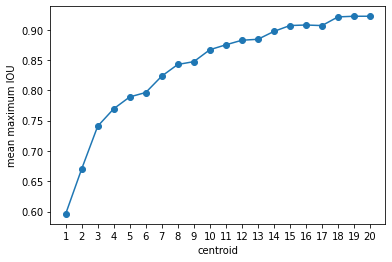

In [0]:
plotIOU(K, mean_iou)

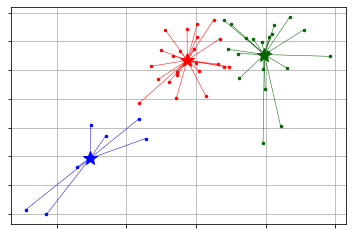

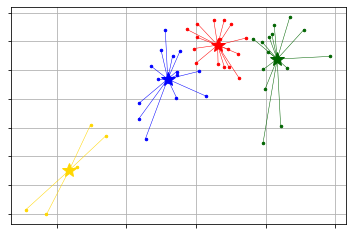

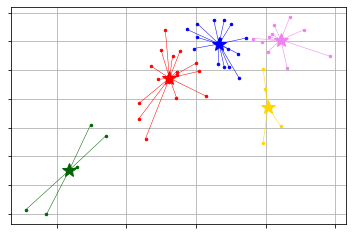

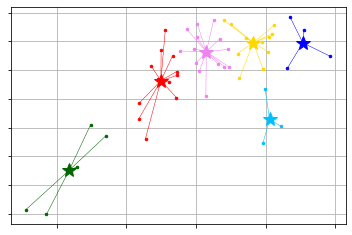

In [0]:

for k in range(2, 6):
  kmeans_visualizer.show_clusters(X, clusters[k], final_centers[k])

PLOT Top 3 Anchor boxes where IOU > 75%

In [0]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def make_anchor_boxes(ax, clusters, facecolor='None', edgecolor='b', alpha=1):

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)
    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
                          fmt='None', ecolor='None')

    return artists

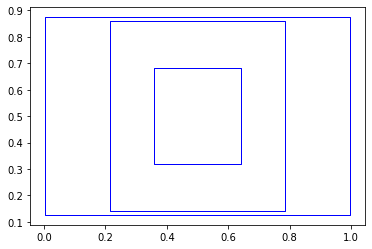

In [0]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Call function to create error boxes
_ = make_anchor_boxes(ax, final_centers[2])

plt.show()

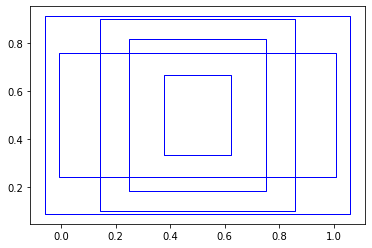

In [0]:

# Create figure and axes
fig, ax = plt.subplots(1)

# Call function to create error boxes
_ = make_anchor_boxes(ax, final_centers[4])

plt.show()